<a href="https://colab.research.google.com/github/porter7678/image_caption_generator/blob/master/image_caption_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###To Do:
 - Get some sort of "embedding" from a CNN.
 - Try to implement the RNN part using PyTorch's built in LSTM
 - Implement the LSTM from the paper


###Fix at the end:
 - Shuffle my dataloader
 - Size images back up
 - Get images to work even if they’re not square
 - I did 'drop_last' on my dataloaders, there is a chance I don't want to do that
 - If I can get the model training on just one caption, is there some way to generalize the loss to account for all 5 captions that I have? Like treat the loss as the lowest out of all 5 captions?
 - Use a different CNN that isn't copying from https://medium.com/@stepanulyanin/captioning-images-with-pytorch-bc592e5fd1a3
 - After getting something running, try to strip it down to just what the paper had (including a CNN from that year)

###Possible improvements:
 - Different CNN
 - Implement Attention
 - Fix the embedding dictionary
 - Teacher forcing
 - Beam search

###Questions
 - What does pin_memory in the DataLoader do?
 - The research paper talks about a "dictionary" is that something I am actually supposed to include, or does that just refer to my collection of captions?
 - Is there any way to know what size the output of my CNN should be?

 ----------------------------------------------


In [0]:
# !pip install torch 
# !pip install torchvision
# !pip install tqdm
# !pip install kaggle

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets, models
from tqdm import tqdm
import os


assert torch.cuda.is_available()

# Data Preparation

In [0]:
os.environ['KAGGLE_USERNAME'] = 'porter7678'
if not 'KAGGLE_KEY' in os.environ:
  os.environ['KAGGLE_KEY'] = input()

In [4]:
# ~70 secs
!kaggle datasets download -d ming666/flicker8k-dataset
!unzip -q flicker8k-dataset.zip

# Discard extra directories
! rm -rf flickr8k_dataset/
! rm -rf flickr8k_text/
! rm -rf sample_data/

# Create Train and Valid directories
os.mkdir('Flickr8k_Dataset/Train_Images')
os.mkdir('Flickr8k_Dataset/Valid_Images')
os.mkdir('Flickr8k_Dataset/Valid_Images/Flicker8k_Dataset_Valid')
os.replace('Flickr8k_Dataset/Flicker8k_Dataset', 'Flickr8k_Dataset/Train_Images/Flicker8k_Dataset_Train')

100% 2.07G/2.08G [00:40<00:00, 68.1MB/s]
100% 2.08G/2.08G [00:40<00:00, 55.2MB/s]


In [0]:
############ - DATATSET README - ################################################################
# Flickr8k.token.txt - the raw captions of the Flickr8k Dataset,
#       the first column is the ID of the caption which is "image address # caption number"
# Flickr8k.lemma.txt - the lemmatized version of the above captions 
# Flickr_8k.trainImages.txt - The list of training images used in our experiments
# Flickr_8k.devImages.txt - The list of development/validation images used in our experiments
# Flickr_8k.testImages.txt - The list of test images used in our experiments
#################################################################################################
# 8091 images

In [0]:
# Create list of images to move to validation folder
valid_img_names = []
file_names = ['Flickr8k_text/Flickr_8k.devImages.txt', 'Flickr8k_text/Flickr_8k.testImages.txt']
for file_name in file_names:
    with open(file_name, 'r') as f:
        for line in f.readlines():
            valid_img_names.append(line.strip())

# Move validation images to validation folder
for file_name in valid_img_names:
    os.replace('Flickr8k_Dataset/Train_Images/Flicker8k_Dataset_Train/' + file_name, 'Flickr8k_Dataset/Valid_Images/Flicker8k_Dataset_Valid/' + file_name)

# Dataset Implementation

In [0]:
def show_imgs(x, new_fig=True):
    '''
    Displays the image contained in a tensor.

    Arguments:
        x ((c,m,n) tensor): The image to be shown
    '''
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

In [0]:
class ImageCaptionDataset(Dataset):
    '''
    Dataset class containing images and captions

    Attributes:
        image_folder (ImageFolder Dataset): Images to be captioned (data)
        caption_folder (Dataset): Captions associated with images for validation (labels)
    '''
    def __init__(self, train=True, img_size=128):
        # Initialize with training images or validation images depending on train parameter
        folder_prefix = 'Train' if train else 'Valid'
        folder_path = 'Flickr8k_Dataset/' + folder_prefix + '_Images'
        self.image_folder = datasets.ImageFolder(root=folder_path,
                                                transform=transforms.Compose([
                                                    transforms.Resize(img_size),
                                                    transforms.CenterCrop(img_size),  # This is the line that is making images square
                                                    transforms.ToTensor(),
                                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                                ]))
        
        # NOTE: There is a chance I need to find a way to stick this caption attribute in a Dataset class for the dataloader to work.
        train_img_captions = []
        valid_img_captions = []
        curr_img_captions = []

        with open('Flickr8k_text/Flickr8k.token.txt', 'r') as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            line = line.strip().split('\t')
            curr_img_captions.append(line[1])

            # Each image has five captions, so start a new caption list each 5 iterations
            if i % 5 == 4:
                img_name = line[0][:-2]
                if img_name in valid_img_names:
                    valid_img_captions.append((img_name, curr_img_captions))
                else:
                    train_img_captions.append((img_name, curr_img_captions))
                curr_img_captions = []

        # Data cleaning: This is an extra caption in the dataset with no image
        train_img_captions.pop(1010)

        self.caption_folder = train_img_captions if train else valid_img_captions

    
    def __getitem__(self, index):
        img = self.image_folder[index]
        captions = self.caption_folder[index]
        return img[0], captions[1]
        

    def __len__(self):
        return len(self.caption_folder)

In [0]:
train_dataset = ImageCaptionDataset(train=True)
valid_dataset = ImageCaptionDataset(train=False)

train_loader = DataLoader(train_dataset, 
                          batch_size=1, 
                          shuffle=False, 
                          pin_memory=True,
                          drop_last=True)
valid_loader = DataLoader(valid_dataset, 
                          batch_size=8, 
                          shuffle=False, 
                          pin_memory=True)

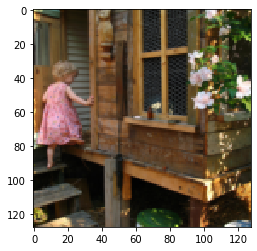

In [10]:
# Make sure everything loaded alright

for test_x, test_y_truth in train_loader:
    for img in test_x:
        show_imgs(img)
        break
    break

# CNN Model

In [11]:
# My output size of 128 is completely arbitrary - I don't know what I should pick
class EncoderCNN(nn.Module):
    def __init__(self, embed_size=1024):
        super(EncoderCNN, self).__init__()

        self.densenet = models.densenet121(pretrained=True)
        self.densenet.classifier = nn.Linear(1024, 1024) # Fully connected layer
        self.embed = nn.Linear(1024, embed_size)
        self.relu = nn.ReLU()

    def forward(self, images):
        outputs = self.relu(self.densenet(images))
        embeddings = self.embed(outputs)
        return embeddings

encoder = EncoderCNN()
encoder = encoder.cuda()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:01<00:00, 20.7MB/s]


In [0]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        # Put LSTM here
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input_word, hidden):
        embedding = self.embedding(input_word).view(1, 1, -1)
        output = F.relu(embedding)
        output, hidden = None # LSTM goes here
        scores = self.out(output[0])

        return scores, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)